In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from spyglass.common import Session, IntervalList, Electrode, get_electrode_indices, interval_list_contains, interval_list_intersect
from spyglass.lfp.v1 import LFPV1
# from spyglass.lfp_band.v1 import LFPBandV1
from spyglass.position import PositionOutput
from spyglass.position.v1 import TrodesPosV1
from tqdm import tqdm


import os
os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/')
from ms_opto_stim_protocol import OptoStimProtocol,OptoStimProtocolParams, OptoStimProtocolTransfected, OptoStimProtocolLaser, OptoStimProtocolClosedLoop
from Analysis.utils import filter_animal, filter_task, filter_opto_data
from Analysis.lfp_analysis import get_ref_electrode_index, power_spectrum
from Analysis.position_analysis import filter_position_ports
from Style.style_guide import transfection_style


os.chdir('/home/sambray/Documents/MS_analysis_samsplaying/')
from Task_event.ms_task_performance import AlternationTaskPerformance
from Task_event.ms_dio_event import DioEvents, ProcessedDioEvents

from Metadata.ms_task_identification import TaskIdentification
from Time_and_trials.ms_interval import EpochIntervalListName

[2025-03-26 08:05:44,565][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-03-26 08:05:44,742][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


## Get the Data

In [ ]:
track_type = "early_wtrack"
inbound_trial = []
trial_velocities = []
opto_trial = []
transfected_trial = []
accuracy = []
animal = ""


#################################
for transfected in [True, False]:
    dataset_key = {
        # 'pulse_length_ms':40,
        # "transfected":True,
        "laser_power": 77,
        "targeted_phase": 90,
        "animal": animal,
        "transfected": transfected,
        "track_type": track_type,
        # "interval_list_name":"pos 3 valid times",
    }
    dataset = filter_opto_data(dataset_key)

    for nwb_file_name, interval_name in tqdm(
        zip(dataset.fetch("nwb_file_name"), dataset.fetch("interval_list_name"))
    ):
        if (
            nwb_file_name == "Bilbo20230802_.nwb"
            and interval_name == "pos 13 valid times"
        ):
            continue
        key = {
            "nwb_file_name": nwb_file_name,
            "interval_list_name": interval_name,
        }
        # outcomes and durations
        outcomes = ((AlternationTaskPerformance() * EpochIntervalListName) & key).fetch(
            "performance_outcomes"
        )
        if not len(outcomes):
            continue
        outcomes = outcomes[0]
        poke_times = (
            (ProcessedDioEvents().FirstUpPokes() * EpochIntervalListName) & key
        ).fetch1("dio_first_poke_times")
        last_poke_times = (
            (ProcessedDioEvents().LastDownPokes() * EpochIntervalListName) & key
        ).fetch1("dio_last_poke_times")
        inbound_trial.extend([("inbound" in x) for x in outcomes[1:]])
        accuracy.extend([("incorrect" in x) for x in outcomes[1:]])

        # speed
        pos_df = (
            TrodesPosV1() & key & {"trodes_pos_params_name": "single_led"}
        ).fetch1_dataframe()
        timestamps = np.array(pos_df.index)
        speed = np.asarray(pos_df.speed)
        trial_intervals = [
            [poke_times[i], poke_times[i + 1]] for i in range(len(poke_times) - 1)
        ]
        travel_intervals = np.array(filter_position_ports(key))
        for trial in trial_intervals:
            intervals = interval_list_intersect(
                np.array(trial)[None, :], travel_intervals
            )
            if not len(intervals):
                trial_velocities.append(np.array([]))
                continue
            trial_velocities.append(
                np.concatenate(
                    [
                        speed[
                            np.where(
                                (timestamps > interval[0]) & (timestamps < interval[1])
                            )[0]
                        ]
                        for interval in intervals
                    ]
                )
            )

        # Dio intervals
        test_intervals = (OptoStimProtocol() & key).fetch1("test_intervals")
        opto_trial.extend(
            [
                interval_list_contains(test_intervals, np.array([i])).size
                for i in poke_times[1:]
            ]
        )

        # transfected
        transfected_trial.extend(np.ones(outcomes.size - 1) * int(transfected))

# trial_durations = np.array(trial_durations)
inbound_trial = np.array(inbound_trial)
opto_trial = np.array(opto_trial).astype(bool)
transfected_trial = np.array(transfected_trial).astype(bool)
accuracy = ~np.array(accuracy).astype(bool)

datasets: 44


44it [08:15, 11.26s/it]


datasets: 42


5it [01:29, 17.56s/it]

## Plot Version 1

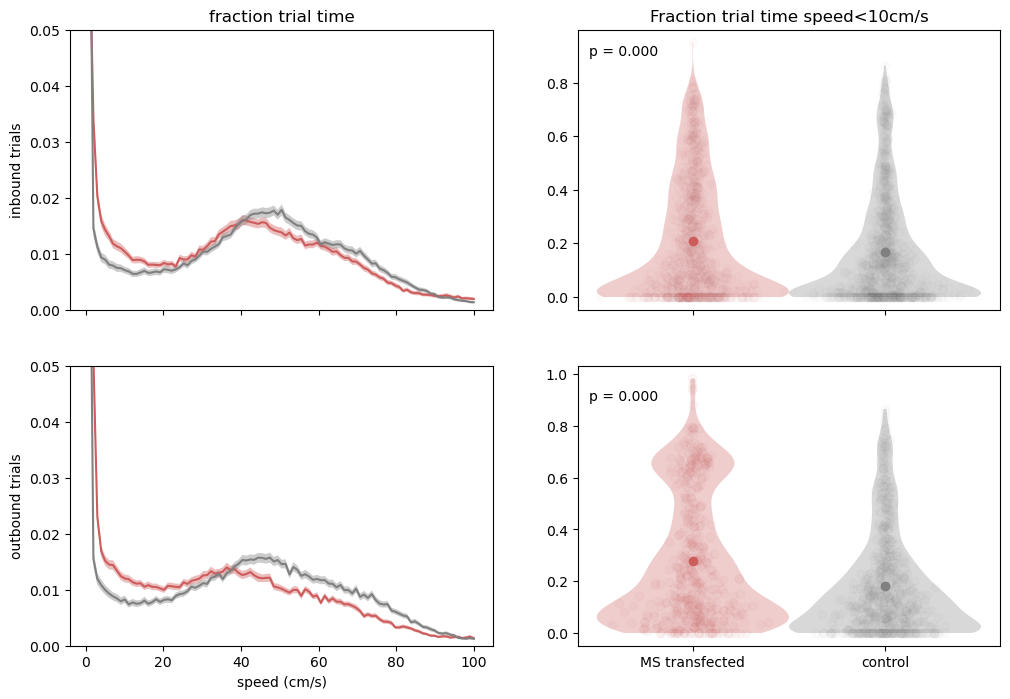

In [4]:
from Analysis.utils import violin_scatter
from scipy.stats import ttest_ind

root_condition = (opto_trial) + ~opto_trial  # & ~inbound_trial
root_condition = [True for _ in opto_trial]
root_condition = accuracy
speed_thresh = 10
pause_time = 30

fig, ax_list = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), sharex="col")
dur_stationary_list = []
for ii, trial_type in enumerate([inbound_trial, ~inbound_trial]):
    base_condition = root_condition & trial_type
    ax = ax_list[ii]
    stationary_list = []
    for i, (filter, color) in enumerate(
        zip([transfected_trial, ~transfected_trial], transfection_style.values())
    ):
        condition = base_condition & filter
        dist = []
        dur_stationary = []
        # for velocity in np.array(trial_velocities)[np.where(condition)[0]]:
        for ii in np.where(condition)[0]:
            velocity = np.array(trial_velocities[ii])
            velocity = velocity[~np.isnan(velocity)]
            val, bins = np.histogram(velocity, bins=np.linspace(0, 100, 100))
            if not val.sum():
                continue
            val = val / val.sum()
            dist.append(val)
            dur_stationary.append((velocity < speed_thresh).sum())
        dur_stationary_list.append(np.array(dur_stationary))
        dist = np.array(dist)
        # ax[0].plot(bins[1:],np.mean(dist,axis=0),c=color)
        # ax[0].fill_between(bins[1:],np.nanpercentile(dist,25,axis=0),np.nanpercentile(dist,75,axis=0),facecolor=color,alpha=.4)
        # c.i plot
        from Analysis.utils import bootstrap_traces

        yy, rng = bootstrap_traces(dist, 1000)
        ax[0].plot(bins[1:], yy, c=color)
        ax[0].fill_between(bins[1:], *rng, facecolor=color, alpha=0.4)

        # stationary time
        ind_stationary = np.where(bins < speed_thresh)[0]

        stationary_fract = np.nansum(dist[:, ind_stationary], axis=1)
        stationary_list.append(stationary_fract)

        violin_scatter(
            stationary_fract, pos=i / 2, ax=ax[1], color=color, bw_method=0.2
        )
        # violin = ax[1].violinplot(stationary_fract,positions=[i/2],
        #            showmedians=False,showextrema=False,points=1000,)
        # for pc in violin['bodies']:
        #     pc.set_facecolor(color)
        #     pc.set_alpha(.5)
        ax[1].scatter(
            [i / 2],
            np.mean(stationary_fract),
            color=color,
        )
        # break
    p_val = ttest_ind(stationary_list[0], stationary_list[1])[1]
    ax[1].text(-0.27, 0.9, f"p = {p_val:.3f}")
ax_list[
    0,
    0,
].set_ylim(0, 0.05)
ax_list[
    1,
    0,
].set_ylim(0, 0.05)
ax[0].set_xlabel("speed (cm/s)")
ax_list[0, 0].set_title("fraction trial time")
ax[1].set_xticks([0.0, 0.5])
ax[1].set_xticklabels(["MS transfected", "control"])
ax_list[0, 1].set_title(f"Fraction trial time speed<{speed_thresh}cm/s")

ax_list[0, 0].set_ylabel("inbound trials")
ax_list[1, 0].set_ylabel("outbound trials")

plt.rcParams["svg.fonttype"] = "none"
# fig.savefig("/home/sambray/Documents/MS_analysis_samsplaying/Plots/fens_2024/velocity_distribution_accurate.svg")
# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/wtrack_speed_dist_CI.svg"
# )

## Plot Version 2

transfected inbound 1096
control inbound 1129
transfected outbound 945
control outbound 1042


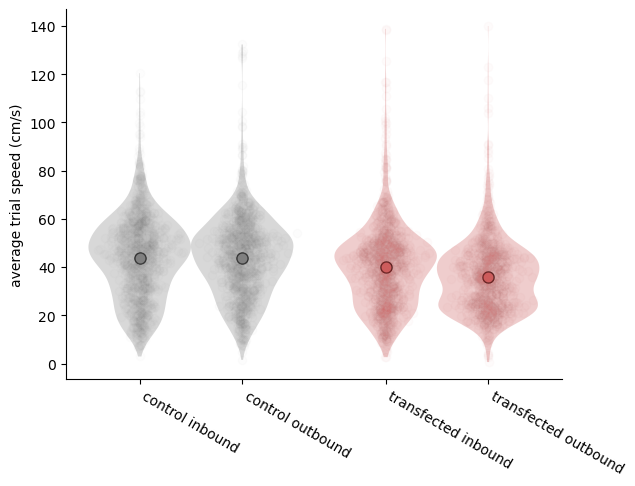

In [6]:
from Analysis.utils import violin_scatter
from scipy.stats import ttest_ind

root_condition = (opto_trial) + ~opto_trial  # & ~inbound_trial
root_condition = [True for _ in opto_trial]  # all trials
# root_condition = ~accuracy

fig = plt.figure()
ax = fig.add_subplot(111)


dur_stationary_list = []
label_locs = []
labels = []
label_locs = []
results = {}
for j, (trial_type, type_name) in enumerate(
    zip(
        [inbound_trial, ~inbound_trial],
        ["inbound", "outbound"],
    )
):

    base_condition = root_condition & trial_type

    for i, (filter, color, group) in enumerate(
        zip(
            [transfected_trial, ~transfected_trial],
            transfection_style.values(),
            ["transfected", "control"],
        )
    ):
        condition = base_condition & filter
        dist = []

        for ii in np.where(condition)[0]:
            velocity = np.array(trial_velocities[ii])
            velocity = velocity[~np.isnan(velocity)][::20]
            # dist.extend(velocity)
            dist.append(np.nanmean(velocity))
        dist = np.array(dist)
        dist = dist[np.isfinite(dist)]
        print(group, type_name, len(dist))
        # dist = np.log10(np.clip(dist, 1e-20, 1e3))
        from Analysis.utils import violin_scatter

        xloc = -i * (1.2) + j / 2
        mid = np.mean(dist)
        plt.scatter(xloc, mid, c=color, edgecolors="k", s=50, lw=2)
        violin_scatter(dist, pos=xloc, color=color, mark_mean=True, ax=ax)
        label_locs.append(xloc)
        labels.append(f"{group} {type_name}")

        if group not in results:
            results[group] = {}
        results[group][type_name] = dist

plt.xticks(label_locs, labels, rotation=-30, ha="left")
plt.ylabel("average trial speed (cm/s)")
ax.spines[["top", "right"]].set_visible(False)
plt.rcParams["svg.fonttype"] = "none"
# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/wtrack_trial_speed_dist.svg"
# )

In [6]:
from scipy.stats import ttest_ind

for animal in results:
    print(animal + ": inbound vs outbound")
    print(
        ttest_ind(
            results[animal]["inbound"], results[animal]["outbound"], equal_var=False
        )[1]
    )

for trial_type in ["inbound", "outbound"]:
    print(trial_type + ": control vs transfected")
    print(
        ttest_ind(
            results["control"][trial_type],
            results["transfected"][trial_type],
            equal_var=False,
        )[1]
    )

transfected: inbound vs outbound
1.9209825178540826e-08
control: inbound vs outbound
0.8514944706632686
inbound: control vs transfected
8.655534432893267e-08
outbound: control vs transfected
4.7828818888205906e-27


# All animals

In [3]:
track_type = "early_wtrack"
# inbound_trial = []
# trial_velocities = []
# opto_trial = []
# transfected_trial = []
# accuracy = []

from Style.style_guide import animal_style

results = {}
#################################
for animal in animal_style.index:
    if animal in ["control", "transfected"]:
        continue
    dataset_key = {
        # 'pulse_length_ms':40,
        # "transfected":True,
        "laser_power": 77,
        "targeted_phase": 90,
        "animal": animal,
        "track_type": track_type,
        # "interval_list_name":"pos 3 valid times",
    }
    inbound_trial = []
    trial_velocities = []
    opto_trial = []
    transfected_trial = []
    accuracy = []

    dataset = filter_opto_data(dataset_key)
    if len(dataset) == 0:
        continue

    for nwb_file_name, interval_name in tqdm(
        zip(dataset.fetch("nwb_file_name"), dataset.fetch("interval_list_name"))
    ):
        if (
            nwb_file_name == "Bilbo20230802_.nwb"
            and interval_name == "pos 13 valid times"
        ):
            continue
        key = {
            "nwb_file_name": nwb_file_name,
            "interval_list_name": interval_name,
        }
        # outcomes and durations
        outcomes = ((AlternationTaskPerformance() * EpochIntervalListName) & key).fetch(
            "performance_outcomes"
        )
        if not len(outcomes):
            continue
        outcomes = outcomes[0]
        poke_times = (
            (ProcessedDioEvents().FirstUpPokes() * EpochIntervalListName) & key
        ).fetch1("dio_first_poke_times")
        last_poke_times = (
            (ProcessedDioEvents().LastDownPokes() * EpochIntervalListName) & key
        ).fetch1("dio_last_poke_times")
        inbound_trial.extend([("inbound" in x) for x in outcomes[1:]])
        accuracy.extend([("incorrect" in x) for x in outcomes[1:]])

        # speed
        pos_df = (
            TrodesPosV1() & key & {"trodes_pos_params_name": "single_led"}
        ).fetch1_dataframe()
        timestamps = np.array(pos_df.index)
        speed = np.asarray(pos_df.speed)
        trial_intervals = [
            [poke_times[i], poke_times[i + 1]] for i in range(len(poke_times) - 1)
        ]
        travel_intervals = np.array(filter_position_ports(key))
        for trial in trial_intervals:
            intervals = interval_list_intersect(
                np.array(trial)[None, :], travel_intervals
            )
            if not len(intervals):
                trial_velocities.append(np.array([]))
                continue
            trial_velocities.append(
                np.concatenate(
                    [
                        speed[
                            np.where(
                                (timestamps > interval[0]) & (timestamps < interval[1])
                            )[0]
                        ]
                        for interval in intervals
                    ]
                )
            )
        assert len(trial_velocities) == len(inbound_trial)
        # Dio intervals
        test_intervals = (OptoStimProtocol() & key).fetch1("test_intervals")
        opto_trial.extend(
            [
                interval_list_contains(test_intervals, np.array([i])).size
                for i in poke_times[1:]
            ]
        )

        # transfected
        transfected_trial.extend(np.ones(outcomes.size - 1) * int(transfected))

    # trial_durations = np.array(trial_durations)
    inbound_trial = np.array(inbound_trial)
    opto_trial = np.array(opto_trial).astype(bool)
    transfected_trial = np.array(transfected_trial).astype(bool)
    accuracy = ~np.array(accuracy).astype(bool)

    results[animal] = {
        "trial_velocities": trial_velocities,
        "inbound_trial": inbound_trial,
    }

datasets: 9


9it [00:16,  1.83s/it]


datasets: 9


9it [00:03,  2.52it/s]


datasets: 10


10it [00:04,  2.40it/s]


datasets: 16


16it [00:06,  2.51it/s]


datasets: 0
datasets: 10


10it [00:47,  4.76s/it]


datasets: 8


8it [00:37,  4.69s/it]


datasets: 16


16it [01:15,  4.74s/it]


datasets: 8


8it [01:01,  7.73s/it]


In [10]:
len(trial_velocities), len(trial_type)

(205, 324)

Winnie: 0.920
Frodo: 0.027
Totoro: 0.624
Banner: 0.000
Wallie: 0.922
Olive: 0.895
Yoshi: 0.863
Bilbo: 0.542


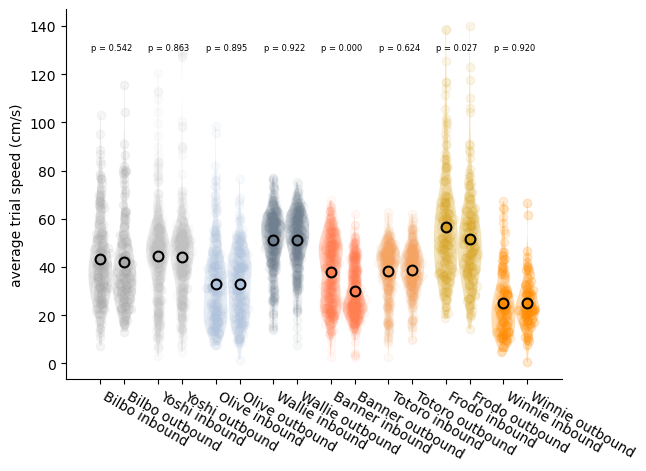

In [5]:
from Analysis.utils import violin_scatter
from scipy.stats import ttest_ind

# root_condition = (opto_trial) + ~opto_trial  # & ~inbound_trial
# root_condition = [True for _ in opto_trial]  # all trials
# root_condition = ~accuracy

fig = plt.figure()
ax = fig.add_subplot(111)


dur_stationary_list = []
label_locs = []
labels = []
label_locs = []
results_2 = {}

for i, (animal, data) in enumerate(results.items()):
    inbound_trial = data["inbound_trial"]
    trial_velocities = data["trial_velocities"]

    ttest_values = []
    for j, (trial_type, type_name) in enumerate(
        zip(
            [inbound_trial, ~inbound_trial],
            ["inbound", "outbound"],
        )
    ):

        base_condition = trial_type

        condition = base_condition
        dist = []

        for ii in np.where(condition)[0]:
            velocity = np.array(trial_velocities[ii])
            velocity = velocity[~np.isnan(velocity)][::20]
            # dist.extend(velocity)
            dist.append(np.nanmean(velocity))
        dist = np.array(dist)
        dist = dist[np.isfinite(dist)]
        # dist = np.log10(np.clip(dist, 1e-20, 1e3))
        from Analysis.utils import violin_scatter

        color = animal_style.loc[animal, "color"]
        xloc = -i * (1.2) + j / 2
        mid = np.mean(dist)

        violin_scatter(dist, pos=xloc, color=color, mark_mean=True, ax=ax)
        plt.scatter(xloc, mid, c=color, edgecolors="k", s=50, lw=1.5)
        label_locs.append(xloc)
        labels.append(f"{animal} {type_name}")

        # if group not in results:
        #     results_2[group] = {}
        # results_2[group][type_name] = dist

        ttest_values.append(dist)
    p_val = ttest_ind(ttest_values[0], ttest_values[1], equal_var=False)[1]
    print(f"{animal}: {p_val:.3f}")
    plt.text(xloc - 0.7, 130, f"p = {p_val:.3f}", fontsize=6)

plt.xticks(label_locs, labels, rotation=-30, ha="left")
plt.ylabel("average trial speed (cm/s)")
ax.spines[["top", "right"]].set_visible(False)
plt.rcParams["svg.fonttype"] = "none"
# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/wtrack_trial_speed_dist_separate_animals.svg"
# )

In [ ]:
[np.mean(x) for x in results["Banner"]["trial_velocities"]]

[20.51513872753219,
 22.076772040286297,
 24.44510891718517,
 21.562052994802414,
 20.91047696581201,
 20.166304650839717,
 23.74756322544788,
 18.986726180355056,
 20.050045891440764,
 18.56048452217714,
 16.687415533012704,
 23.97473896952675,
 13.21558984447509,
 15.130524579323357,
 21.651791200298412,
 22.30919998308817,
 23.8063047669064,
 19.144410107661333,
 19.964122177819316,
 14.04590204552883,
 25.056530864747455,
 20.722524515649205,
 20.443390025213088,
 23.93479935077149,
 19.26560939245697,
 16.018473311347968,
 16.04766060827907,
 12.416095673365007,
 15.210018177801347,
 11.901849480409965,
 10.601377016282768,
 13.234991142305129,
 16.509356488536024,
 13.625948846793372,
 15.456072672222865,
 21.210534526462542,
 18.721345518927496,
 10.834590058648342,
 14.258919439500923,
 19.60978562748711,
 12.09742977004297,
 10.511588048664402,
 13.23762649048058,
 15.546503319923273,
 9.44293188360902,
 14.546469094413734,
 24.09846967044045,
 20.011871113193106,
 24.38025943

In [ ]:
import statsmodels.api as sms
import pandas as pd

model_df = []
for i, animal in enumerate(results.keys()):
    trial_v = np.array([np.nanmean(x) for x in results[animal]["trial_velocities"]])
    trial_in = results[animal]["inbound_trial"]
    ind = np.isnan(trial_v)
    trial_v = trial_v[~ind]
    trial_in = trial_in[~ind]
    print(animal, np.max(trial_v))
    for v, trial_type in zip(trial_v, trial_in):
        model_df.append(
            {
                "Animal": i,
                "Treatment": (
                    "transfected"
                    if animal_style.loc[animal, "background"] == "indianred"
                    else "control"
                ),
                "Trial_Type": "inbound" if trial_type else "outbound",
                "Score": v,
            }
        )
    # break

model_df = pd.DataFrame(model_df)

from statsmodels.formula.api import mixedlm

# Convert the 'Treatment' column to a categorical variable
model_df["Treatment"] = model_df["Treatment"].astype("category")
model_df["Trial_Type"] = model_df["Trial_Type"].astype("category")
# model_df['Animal'] = model_df['Treatment'].astype('category')

# Fit the mixed-effects model
model = mixedlm("Score ~ Treatment * Trial_Type", model_df, groups=model_df["Animal"])
result = model.fit()

# Print the summary of the model
print(result.summary())
result.pvalues

Winnie 82.34201519943116
Frodo 127.03399171739714
Totoro 60.081872315800446
Banner 68.04038178235504
Wallie 69.43357590140754
Olive 101.33303901995122
Yoshi 124.24603137677207
Bilbo 106.38867554137028
                           Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            Score      
No. Observations:             4212               Method:                        REML       
No. Groups:                   8                  Scale:                         205.9939   
Min. group size:              205                Log-Likelihood:                -17210.6857
Max. group size:              876                Converged:                     Yes        
Mean group size:              526.5                                                        
-------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z|  [0.025 0.975

Intercept                                          2.523734e-19
Treatment[T.transfected]                           6.090717e-01
Trial_Type[T.outbound]                             1.351889e-01
Treatment[T.transfected]:Trial_Type[T.outbound]    6.516803e-04
Group Var                                          8.433142e-02
dtype: float64

# Dev

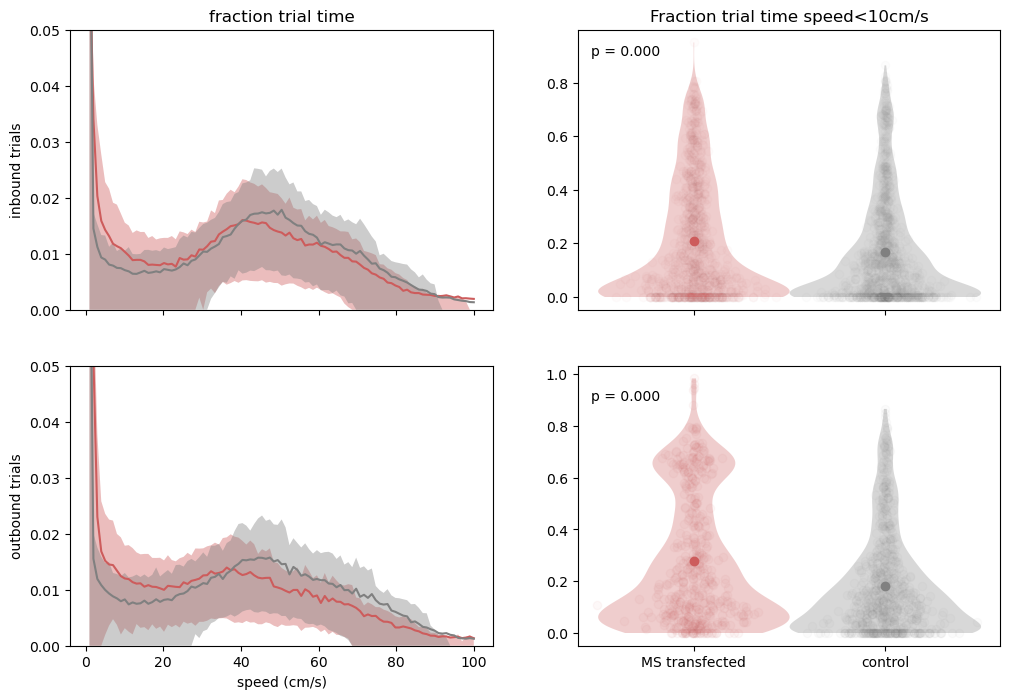

In [56]:
from Analysis.utils import violin_scatter
from scipy.stats import ttest_ind

root_condition = (opto_trial) + ~opto_trial  # & ~inbound_trial
root_condition = [True for _ in opto_trial]
root_condition = accuracy
speed_thresh = 10


fig, ax_list = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), sharex="col")
for ii, trial_type in enumerate([inbound_trial, ~inbound_trial]):
    base_condition = root_condition & trial_type
    ax = ax_list[ii]
    stationary_list = []
    for i, (filter, color) in enumerate(
        zip([transfected_trial, ~transfected_trial], transfection_style.values())
    ):
        condition = base_condition & filter
        dist = []
        # for velocity in np.array(trial_velocities)[np.where(condition)[0]]:
        for ii in np.where(condition)[0]:
            velocity = np.array(trial_velocities[ii])
            velocity = velocity[~np.isnan(velocity)]
            val, bins = np.histogram(velocity, bins=np.linspace(0, 100, 100))
            if not val.sum():
                continue
            val = val / val.sum()
            dist.append(val)
        dist = np.array(dist)
        ax[0].plot(bins[1:], np.mean(dist, axis=0), c=color)
        ax[0].fill_between(
            bins[1:],
            np.nanpercentile(dist, 25, axis=0),
            np.nanpercentile(dist, 75, axis=0),
            facecolor=color,
            alpha=0.4,
        )
        # stationary time
        ind_stationary = np.where(bins < speed_thresh)[0]

        stationary_fract = np.nansum(dist[:, ind_stationary], axis=1)
        stationary_list.append(stationary_fract)
        violin_scatter(
            stationary_fract, pos=i / 2, ax=ax[1], color=color, bw_method=0.2
        )
        # violin = ax[1].violinplot(stationary_fract,positions=[i/2],
        #            showmedians=False,showextrema=False,points=1000,)
        # for pc in violin['bodies']:
        #     pc.set_facecolor(color)
        #     pc.set_alpha(.5)
        ax[1].scatter(
            [i / 2],
            np.mean(stationary_fract),
            color=color,
        )
        # break
    p_val = ttest_ind(stationary_list[0], stationary_list[1])[1]
    ax[1].text(-0.27, 0.9, f"p = {p_val:.3f}")
ax_list[
    0,
    0,
].set_ylim(0, 0.05)
ax_list[
    1,
    0,
].set_ylim(0, 0.05)
ax[0].set_xlabel("speed (cm/s)")
ax_list[0, 0].set_title("fraction trial time")
ax[1].set_xticks([0.0, 0.5])
ax[1].set_xticklabels(["MS transfected", "control"])
ax_list[0, 1].set_title(f"Fraction trial time speed<{speed_thresh}cm/s")

ax_list[0, 0].set_ylabel("inbound trials")
ax_list[1, 0].set_ylabel("outbound trials")

plt.rcParams["svg.fonttype"] = "none"
# fig.savefig("/home/sambray/Documents/MS_analysis_samsplaying/Plots/fens_2024/velocity_distribution_accurate.svg")
# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/wtrack_speed_dist.svg"
# )